In [1]:
#SIZE_TEST = 50000
N_SENTENCES_TRAIN = 2500 # 25000
N_SENTENCES_TEST = 1000 # 1000
N_EPOCHS = 2
CACHED = True

In [2]:
import sys
sys.path.append('../src')

In [3]:
import numpy as np

# Creates Dataset

In [4]:
# Creates Arithmetic dataset
import dataset
reload(dataset)

data_obj = dataset.LeftArithmetic()
data_obj.create(n_sentences_train=N_SENTENCES_TRAIN, n_sentences_test=N_SENTENCES_TEST, cfactor=.25)

Using TensorFlow backend.


Generating raw text, with training size: 2500 and testing size 1000
Generated train sequence - 165868 characters
Generated test sequence - 63316 characters
Total vocabulary size:  17
Total Patterns:  165833
Total Patterns:  63281


In [5]:
print data_obj.train['X'].shape
print data_obj.train['y'].shape
print len(data_obj.train_raw)
print ''
print data_obj.test['X'].shape
print data_obj.test['y'].shape
print len(data_obj.test_raw)
print data_obj.test_raw[:50]

(165833, 35, 17)
(165833, 17)
165868

(63281, 35, 17)
(63281, 17)
63316
['?', '(', '/', '(', '*', '(', '+', '(', '-', '4', '9', ')', '4', ')', '(', '-', '7', '(', '-', '(', '+', '7', '1', ')', '7', ')', ')', ')', '(', '+', '(', '*', '9', '(', '/', '(', '-', '(', '+', '5', '1', ')', '2', ')', '2', ')', ')', '(', '-', '(']


# Creates and trains character model

In [6]:
import model
reload(model)

nn_model = model.VanillaLSTM(data_obj, 128, n_epochs=1)
nn_model.build()

if CACHED:
    nn_model.load_from_file('../models/left_arithmetic_0')
else:
    for i in range(N_EPOCHS):
        nn_model.train()
        nn_model.save('../models/left_arithmetic_' + str(i))

In [7]:
# Creates a sentence

nn_model.complete_sentence(50)

Dimensions: (1, 35, 17)
[16  0  2  0  5  0  4  7  0  3  0  5  9 10  1  0  4  0  2  0  5 15  0  3 14
  0  4  0  2  8  6  1  9  1  1  1  1  1  0  3  0  4  0  3 13  0  5  7 11  1
  1  0  5  0  2  0  5  6 15  1 12  1  0  3 14 12  1  1  1  0  4  0  4 11  0
  2  9 11  1  1  0  2 10  0  4]


'?(*(/(-1(+(/34)(-(*(/9(+8(-(*20)3)))))(+(-(+7(/15))(/(*(/09)6)(+86)))(-(-5(*35))(*4(-'

# Extracts States

In [8]:
# Gets hidden states
states = nn_model.extract_states()
print states.shape

(63316, 32)


# Creates Features

In [9]:
import features
reload(features)

features_obj = features.GrammarFeature(data_obj)
features_obj.build_feature_functions()
computed_features = features_obj.compute_feat_matrix()

print computed_features['feat_matrix'].shape
print len(computed_features['labels'])

Parsed 0 symbols out of 63316
Stack size: 0
Parsed 1000 symbols out of 63316
Stack size: 21
Parsed 2000 symbols out of 63316
Stack size: 19
Parsed 3000 symbols out of 63316
Stack size: 9
Parsed 4000 symbols out of 63316
Stack size: 15
Parsed 5000 symbols out of 63316
Stack size: 1
Parsed 6000 symbols out of 63316
Stack size: 3
Parsed 7000 symbols out of 63316
Stack size: 9
Parsed 8000 symbols out of 63316
Stack size: 7
Parsed 9000 symbols out of 63316
Stack size: 15
Parsed 10000 symbols out of 63316
Stack size: 21
Parsed 11000 symbols out of 63316
Stack size: 13
Parsed 12000 symbols out of 63316
Stack size: 17
Parsed 13000 symbols out of 63316
Stack size: 13
Parsed 14000 symbols out of 63316
Stack size: 13
Parsed 15000 symbols out of 63316
Stack size: 19
Parsed 16000 symbols out of 63316
Stack size: 11
Parsed 17000 symbols out of 63316
Stack size: 19
Parsed 18000 symbols out of 63316
Stack size: 27
Parsed 19000 symbols out of 63316
Stack size: 19
Parsed 20000 symbols out of 63316
Stack

# Computes scores

In [ ]:
import score

score_obj = score.MultiNeuronPred(states, 
                computed_features['feat_matrix'],
                computed_features['labels'])
score_obj.compute_scores()

print score_obj.neuron_scores.shape
print score_obj.model_scores

Scoring feature 0 out of 30
Feature: trig_SENTENCE
Fitting model
Cant compute score
Feature: trig_EXPR
Fitting model
Computing score
Accuracy: 0.73320798868
Feature: trig_MIN
Fitting model
Computing score
Accuracy: 0.884080240803
Feature: trig_N
Fitting model
Computing score
Accuracy: 0.784150367003
Feature: trig_ADD
Fitting model
Computing score
Accuracy: 0.884875768546
Feature: trig_MUL
Fitting model
Computing score
Accuracy: 0.884913694875
Feature: trig_DIV
Fitting model
Computing score
Accuracy: 0.885046318747
Feature: trig_DATASET
Fitting model
Computing score
Accuracy: 0.999959878609
Feature: depth_SENTENCE_1
Fitting model
Cant compute score
Feature: depth_SENTENCE_*
Fitting model
Cant compute score
Scoring feature 10 out of 30
Feature: depth_EXPR_1
Fitting model
Computing score
Accuracy: 0.0825515354604
Feature: depth_EXPR_2
Fitting model
Computing score
Accuracy: 0.115448367386
Feature: depth_EXPR_*
Fitting model
Computing score
Accuracy: 0.999967900878
Feature: depth_MIN_1
Fit

In [17]:
# First viz: shows score per rule

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import os
import numpy as np
%matplotlib inline


fig_size = [25,15]
plt.rcParams["figure.figsize"] = fig_size

feat_scores = score_obj.model_scores
feat_names =  computed_features['labels']
print 'Feature scores:', len(feat_scores)
print 'Features:', len(feat_names)

dorder = np.argsort(feat_scores)[::-1][:50]

scores = np.array(feat_scores)[dorder]
names = np.array(feat_names)[dorder]

fig, ax = plt.subplots()
plt.bar(np.arange(dorder.shape[0]), scores)
plt.xticks(np.arange(dorder.shape[0]), names, rotation='vertical')

plt.show()
# print feat_names[order]

Feature scores: 32
Features: 30


IndexError: index 31 is out of bounds for axis 1 with size 30

Filtering feature matrix


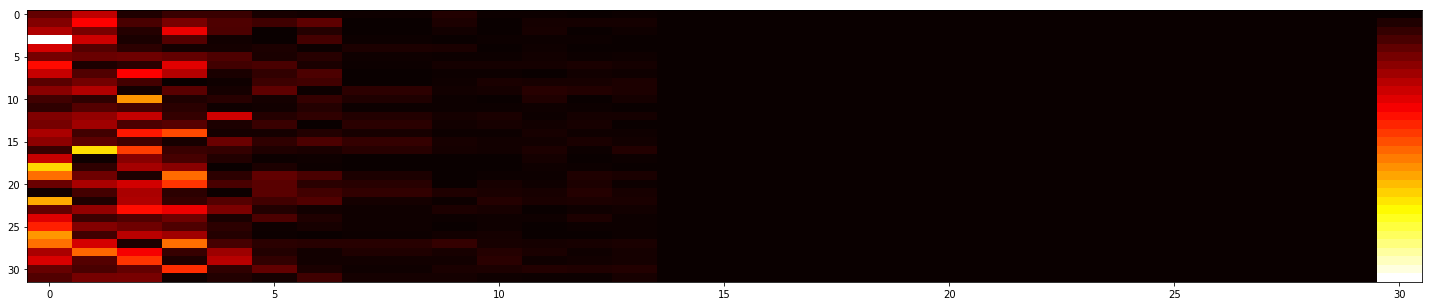

0 trig_SENTENCE
1 trig_EXPR
2 trig_MIN
3 trig_N
4 trig_ADD
5 trig_MUL
6 trig_DIV
7 trig_DATASET
8 depth_SENTENCE_1
9 depth_SENTENCE_*
10 depth_EXPR_1
11 depth_EXPR_2
12 depth_EXPR_*
13 depth_MIN_1
14 depth_MIN_2
15 depth_MIN_*
16 depth_N_1
17 depth_N_*
18 depth_ADD_1
19 depth_ADD_2
20 depth_ADD_*
21 depth_MUL_1
22 depth_MUL_2
23 depth_MUL_*
24 depth_DIV_1
25 depth_DIV_2
26 depth_DIV_*
27 depth_DATASET_1
28 depth_DATASET_2
29 depth_DATASET_*


In [12]:
# Second viz: shows neurons activated for each rule

N_FEATURES_TO_PLOT = 35

to_plot = score_obj.filter_scores(N_FEATURES_TO_PLOT)

n_values   = to_plot.shape[0]
dummy_vals = np.linspace(0,np.max(to_plot),num=n_values)
dummy_vals = np.expand_dims(dummy_vals, axis=1)
to_plot  = np.append(to_plot, dummy_vals, axis = 1)

plt.imshow(to_plot, cmap='hot',
                      norm=Normalize(vmin=0),
                      interpolation='nearest',
                      aspect='auto')
plt.show()
#plt.savefig('correlation_matrix.pdf',  bbox_inches='tight')

for i,l in enumerate(computed_features['labels'][:N_FEATURES_TO_PLOT]):
    print i,l

In [13]:
print len(computed_features['labels'])
print computed_features['feat_matrix'].shape

30
(63316, 30)


# Computes Neuron-specific scores

In [14]:
reload(score)
score_obj = score.CorrelationScore(states, computed_features['feat_matrix'], 
                computed_features['labels'])
score_obj.compute_scores()

#print score_obj.neuron_scores
#print score_obj.model_scores
#print score_obj.feature_names

print len(score_obj.model_scores)
print score_obj.neuron_scores.shape
print len(score_obj.feature_names)

Scoring feature 0 out of 30


/Users/thib/.virtualenvs/keras/lib/python2.7/site-packages/numpy/lib/function_base.py:3162: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/thib/.virtualenvs/keras/lib/python2.7/site-packages/numpy/lib/function_base.py:3163: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Scoring feature 10 out of 30
Scoring feature 20 out of 30
Scoring feature 29 out of 30
32
(32, 30)
30


(32, 30)
30


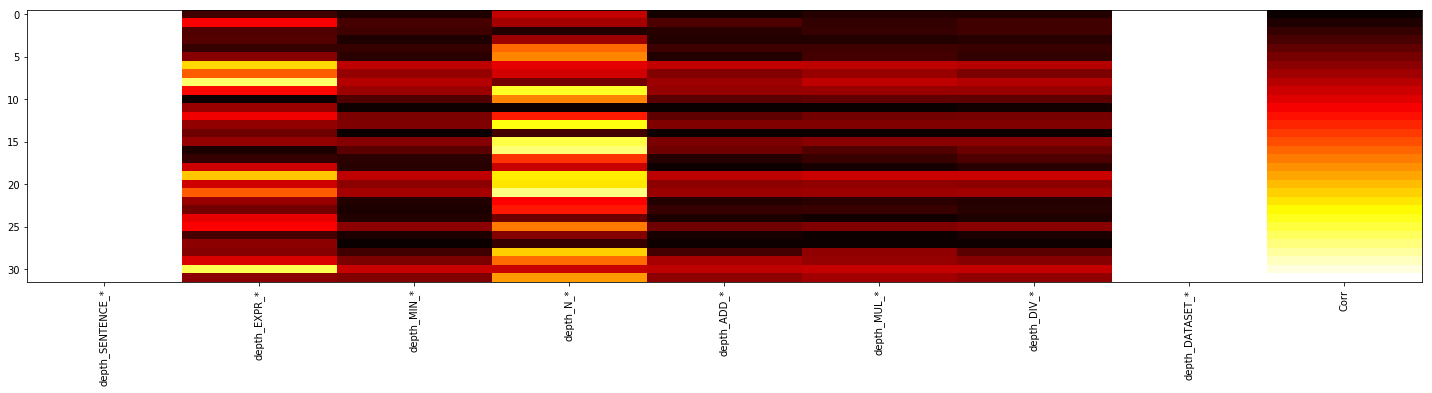

['trig_SENTENCE', 'trig_EXPR', 'trig_MIN', 'trig_N', 'trig_ADD', 'trig_MUL', 'trig_DIV', 'trig_DATASET', 'depth_SENTENCE_1', 'depth_SENTENCE_*', 'depth_EXPR_1', 'depth_EXPR_2', 'depth_EXPR_*', 'depth_MIN_1', 'depth_MIN_2', 'depth_MIN_*', 'depth_N_1', 'depth_N_*', 'depth_ADD_1', 'depth_ADD_2', 'depth_ADD_*', 'depth_MUL_1', 'depth_MUL_2', 'depth_MUL_*', 'depth_DIV_1', 'depth_DIV_2', 'depth_DIV_*', 'depth_DATASET_1', 'depth_DATASET_2', 'depth_DATASET_*']


In [15]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import os
import numpy as np

# Setup of figure
fig_size = [25,5]
plt.rcParams["figure.figsize"] = fig_size

# Gets data to plot
to_plot = score_obj.neuron_scores
print to_plot.shape
feat_names = score_obj.feature_names[:]
print len(feat_names)

# Sorts by alphabetical order
idx = sorted(range(len(feat_names)), key=lambda x:feat_names[i])
to_plot = to_plot[:,idx]
feat_names = [feat_names[i] for i in idx]

# IF NECESSARY FILTERS:
idx = [i for i,f in enumerate(feat_names) if '*' in f]
to_plot = to_plot[:,idx]
feat_names = [feat_names[i] for i in idx]

# Adds dummy column for legend
n_values   = to_plot.shape[0]
dummy_vals = np.linspace(0,1,num=n_values)
dummy_vals = np.expand_dims(dummy_vals, axis=1)
to_plot  = np.append(to_plot, dummy_vals, axis = 1)
feat_names.append('Corr')

fig, ax = plt.subplots()
plt.imshow(to_plot, cmap='hot',
                      norm=Normalize(vmin=0),
                      interpolation='nearest',
                      aspect='auto')
plt.xticks(np.arange(len(feat_names)), feat_names, rotation='vertical')
plt.show()
#plt.savefig('correlation_matrix.pdf',  bbox_inches='tight')

print computed_features['labels'][:N_FEATURES_TO_PLOT]

(32, 30)
30
depth_SENTENCE_*
depth_EXPR_*
depth_MIN_*
depth_N_*
depth_ADD_*
depth_MUL_*
depth_DIV_*
depth_DATASET_*


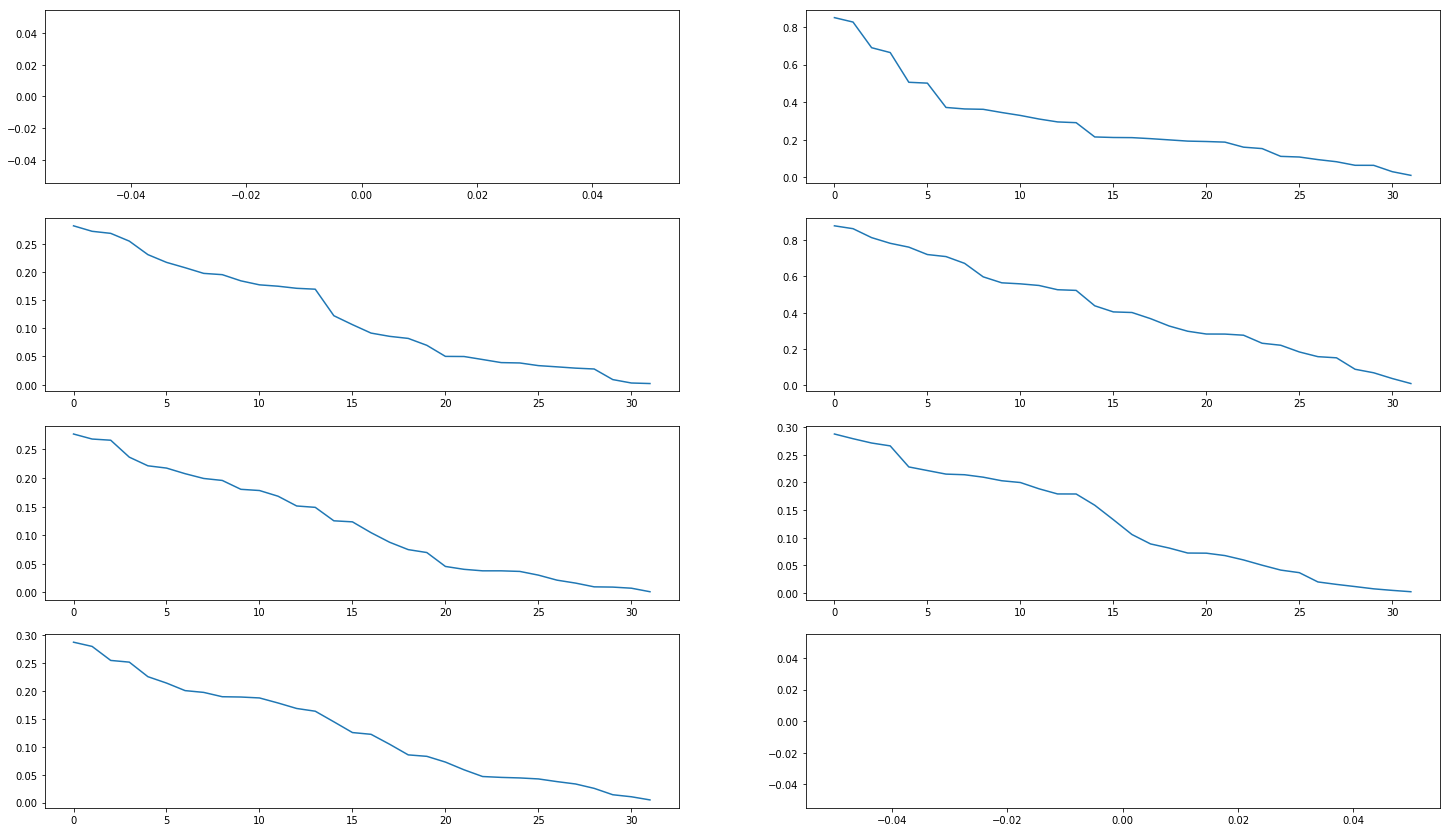

In [16]:
# Second viz
# Setup of figure
fig_size = [25,30]
plt.rcParams["figure.figsize"] = fig_size

# Gets data to plot
to_plot = score_obj.neuron_scores
print to_plot.shape
feat_names = score_obj.feature_names[:]
print len(feat_names)

# Sorts by alphabetical order
idx = sorted(range(len(feat_names)), key=lambda x:feat_names[i])
to_plot = to_plot[:,idx]
feat_names = [feat_names[i] for i in idx]

# IF NECESSARY FILTERS:
idx = [i for i,f in enumerate(feat_names) if '*' in f]
to_plot = to_plot[:,idx]
feat_names = [feat_names[i] for i in idx]


if to_plot.shape[1] <= 4:
    ncol = 1
elif 4 < to_plot.shape[1] <= 8:
    ncol = 2
else:
    nplots = min(12, to_plot.shape[1])
    to_plot = to_plot[:,:nplots]
    ncol = 3

for i in range(to_plot.shape[1]):
    print feat_names[i]
    neuron_series = np.sort(to_plot[:,i])[::-1]
    plt.subplot(to_plot.shape[1],ncol,i+1)
    plt.plot(neuron_series)

plt.show()